<a href="https://colab.research.google.com/github/Mohamed-Fedi-Belaid/Product_Category_Prediction_using_ML/blob/main/Copy_of_Product_Category_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import Relevant Libraries

In [ ]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import re
import sys
import warnings
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
import joblib

## Full Machine Learning Pipeline

We are explected to build an api that can predict possible categories for any product. We will be using product name and it's description to find relevant categories.

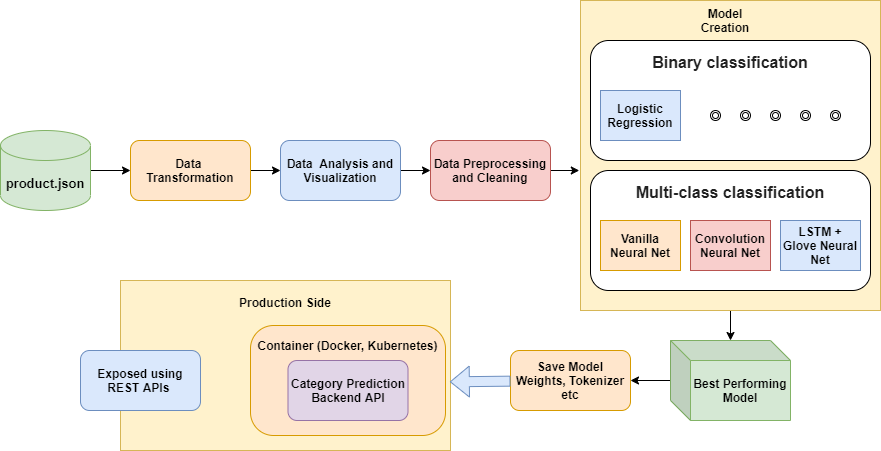

I have followed the CRISP-DM Process:

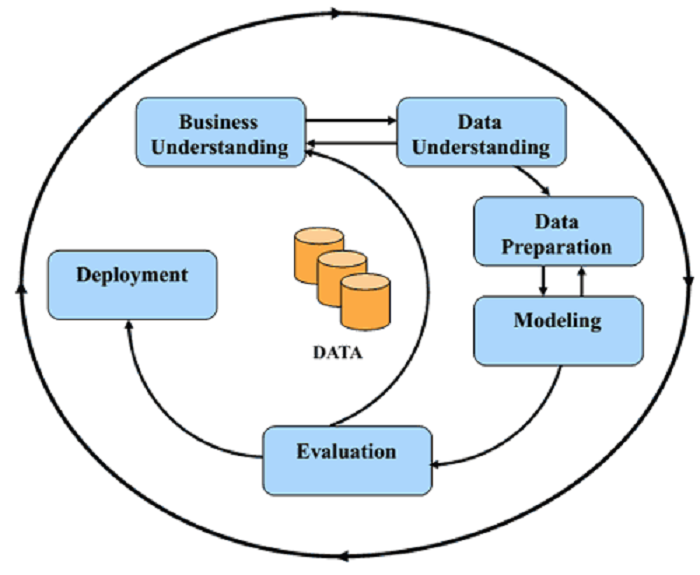

## Import Dataset
# Digidis Dataset
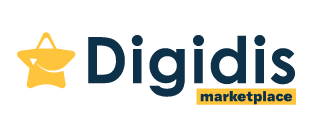



It contains data in the form of json file:  products.json

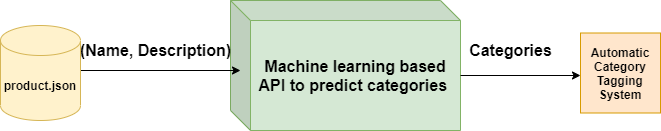

The stores.json contains information like store id, type, name, address, hours etc which is not relevant for this task at this point.
The categories.json list different categories from which our predictions will belong to, but will not be used for our work.
The file used is product.json which contains the product names, description and their categories, from which our model will learn to tag categories to new products.

In [ ]:
f = open('drive/My Drive/datasets/Netflix/product.json')
data = json.load(f) # returns JSON object as a dictionary

In [ ]:
data[20]

{'id': 1,
 'id_frs': 22,
 'idcat': 1,
 'idscat': 0,
 'idsscat': 0,
 'ref': '366',
 'qte': '988',
 'prix_achat': '12',
 'prix_vente': None,
 'prix_vente_affiche': '12.000',
 'prix_old': None,
 'description': '<ul><li>&nbsp;Liquide vaisselle -&nbsp;X-CLEAN</li><li>Contenance : 4 litres</li></ul>',
 'img1': '655de55eb7b63.jpg',
 'img2': None,
 'img3': None,
 'img4': None,
 'img5': None,
 'etat': 1,
 'date_add': '2023-11-22',
 'date_upd': None,
 'presentation': '<p>Le liquide vaisselle X-CLEAN en format de 4 litres offre une solution efficace pour nettoyer la vaisselle &agrave; la main. Formul&eacute; pour &eacute;liminer les graisses et les r&eacute;sidus alimentaires, il laisse la vaisselle propre et fra&icirc;che. Id&eacute;al pour un usage quotidien, il assure un lavage efficace tout en pr&eacute;servant la brillance des ustensiles.</p><p>&nbsp;</p><p>&nbsp;</p><p>&nbsp;</p><p>&nbsp;</p><p>&nbsp;</p><p>&nbsp;</p>',
 'flash': 0,
 'marque': 0,
 'modele': None,
 'couleur': None,
 'deliver

In [187]:
# creating dataframe with three rows (article,description,categorie)
column_names = ['article','descriptions','categorie']
df = pd.DataFrame(columns = column_names)
df

,article,descriptions,categorie


In [188]:
article, descriptions, categorie = [], [], []
for product in data:
    article.append(product['article'])
    descriptions.append(product['presentation'])
    categorie.append(product['category'])
df = pd.DataFrame(list(zip(article, descriptions, categorie)), columns=column_names)

In [189]:
df

,article,descriptions,categorie
0,Judy Vitres - Triple Action - 500 ml,<p>Judy Vitres Triple Action excelle dans l&#3...,SantÃ© et BeautÃ©
1,Netto Confort - Essuies-Tout,"<p>Les essuies-tout Netto Confort, livr&eacute...",SantÃ© et BeautÃ©
2,Lilas - DÃ©sodorisant - 3L,<p>Le d&eacute;sodorisant sol de 3 L est un ch...,SantÃ© et BeautÃ©
3,Judy Clorogel - 1.5 L,<p>Judy Clorogel est sp&eacute;cialement con&c...,SantÃ© et BeautÃ©
4,X Clean - DÃ©tachant Ã Tissu - 7in1 250ML,<p>&nbsp;X Clean est un d&eacute;tachant &agra...,SantÃ© et BeautÃ©
...,...,...,...
597,Rame Papier - 500 feuilles - A4 - 1 TND - Oore...,"<p>Ces 500 feuilles, comprenant 50 vouchers Oo...",Recharge tÃ©lÃ©phonique
598,Rame Papier - 500 feuilles - A4 - 5TND - Ooredoo,"<p>Ces 500 feuilles, comprenant 50 vouchers Oo...",Recharge tÃ©lÃ©phonique
599,Rame Papier - 500 feuilles - A4 - 1 TND - Tuni...,"<p>Ces 500 feuilles, comprenant 50 vouchers Tu...",Recharge tÃ©lÃ©phonique
600,Rame Papier - 500 feuilles - A4 - 5 TND - Tuni...,"<p>Ces 500 feuilles, comprenant 50 vouchers Tu...",Recharge tÃ©lÃ©phonique


There are total **51646** products listed in the product.json file.
As each instanse can belong to multiple categories, so these types of problems are known as **multi-label classification problem**, where we have a set of target labels.
If there are multiple categories but each instance is assigned only one, therefore such problems are known as **multi-class classification problem**.

Multi-class problem acknowledge that all the classes are mutually exclusive, but in our case it is not as a product can belong to multiple classes/categories.

In [190]:
cat = pd.DataFrame(df['categorie'].unique()) # listing the categories seperately
cat

,0
0,SantÃ© et BeautÃ©
1,Fourniture Scolaire et Bureautique
2,Agroalimentaire
3,Jeux & Jouets
4,High-Tech
5,Recharge tÃ©lÃ©phonique


InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [191]:
df2 = pd.concat([df['article'],df['descriptions'],df['categorie']],axis=1) # creating new dataframe which contains name of product,description and categories it belong to
df2.head()

,article,descriptions,categorie
0,Judy Vitres - Triple Action - 500 ml,<p>Judy Vitres Triple Action excelle dans l&#3...,SantÃ© et BeautÃ©
1,Netto Confort - Essuies-Tout,"<p>Les essuies-tout Netto Confort, livr&eacute...",SantÃ© et BeautÃ©
2,Lilas - DÃ©sodorisant - 3L,<p>Le d&eacute;sodorisant sol de 3 L est un ch...,SantÃ© et BeautÃ©
3,Judy Clorogel - 1.5 L,<p>Judy Clorogel est sp&eacute;cialement con&c...,SantÃ© et BeautÃ©
4,X Clean - DÃ©tachant Ã Tissu - 7in1 250ML,<p>&nbsp;X Clean est un d&eacute;tachant &agra...,SantÃ© et BeautÃ©


In [192]:
cat_encoded = pd.get_dummies(df['categorie'])
df = pd.concat([df, cat_encoded], axis=1)
df = df.drop('categorie', axis=1)
df

,article,descriptions,Agroalimentaire,Fourniture Scolaire et Bureautique,High-Tech,Jeux & Jouets,Recharge tÃ©lÃ©phonique,SantÃ© et BeautÃ©
0,Judy Vitres - Triple Action - 500 ml,<p>Judy Vitres Triple Action excelle dans l&#3...,False,False,False,False,False,True
1,Netto Confort - Essuies-Tout,"<p>Les essuies-tout Netto Confort, livr&eacute...",False,False,False,False,False,True
2,Lilas - DÃ©sodorisant - 3L,<p>Le d&eacute;sodorisant sol de 3 L est un ch...,False,False,False,False,False,True
3,Judy Clorogel - 1.5 L,<p>Judy Clorogel est sp&eacute;cialement con&c...,False,False,False,False,False,True
4,X Clean - DÃ©tachant Ã Tissu - 7in1 250ML,<p>&nbsp;X Clean est un d&eacute;tachant &agra...,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...
597,Rame Papier - 500 feuilles - A4 - 1 TND - Oore...,"<p>Ces 500 feuilles, comprenant 50 vouchers Oo...",False,False,False,False,True,False
598,Rame Papier - 500 feuilles - A4 - 5TND - Ooredoo,"<p>Ces 500 feuilles, comprenant 50 vouchers Oo...",False,False,False,False,True,False
599,Rame Papier - 500 feuilles - A4 - 1 TND - Tuni...,"<p>Ces 500 feuilles, comprenant 50 vouchers Tu...",False,False,False,False,True,False
600,Rame Papier - 500 feuilles - A4 - 5 TND - Tuni...,"<p>Ces 500 feuilles, comprenant 50 vouchers Tu...",False,False,False,False,True,False


In [193]:
df.shape
df2 = df

There are **51646** product with **1802** classes/category.

## Data Analysis

Count of occurance of each category, to check most frequently occuring categories.

In [194]:
bar_plot = pd.DataFrame()
bar_plot['categorie'] = df2.columns[2:] # column name, which are categories
bar_plot['count'] = df2.iloc[:,2:].sum().values
bar_plot.sort_values(['count'], inplace=True, ascending=False)
bar_plot.reset_index(inplace=True, drop=True)
bar_plot.head() # Top 5 most occuring categories

,categorie,count
0,High-Tech,269
1,Agroalimentaire,185
2,SantÃ© et BeautÃ©,74
3,Fourniture Scolaire et Bureautique,35
4,Jeux & Jouets,26


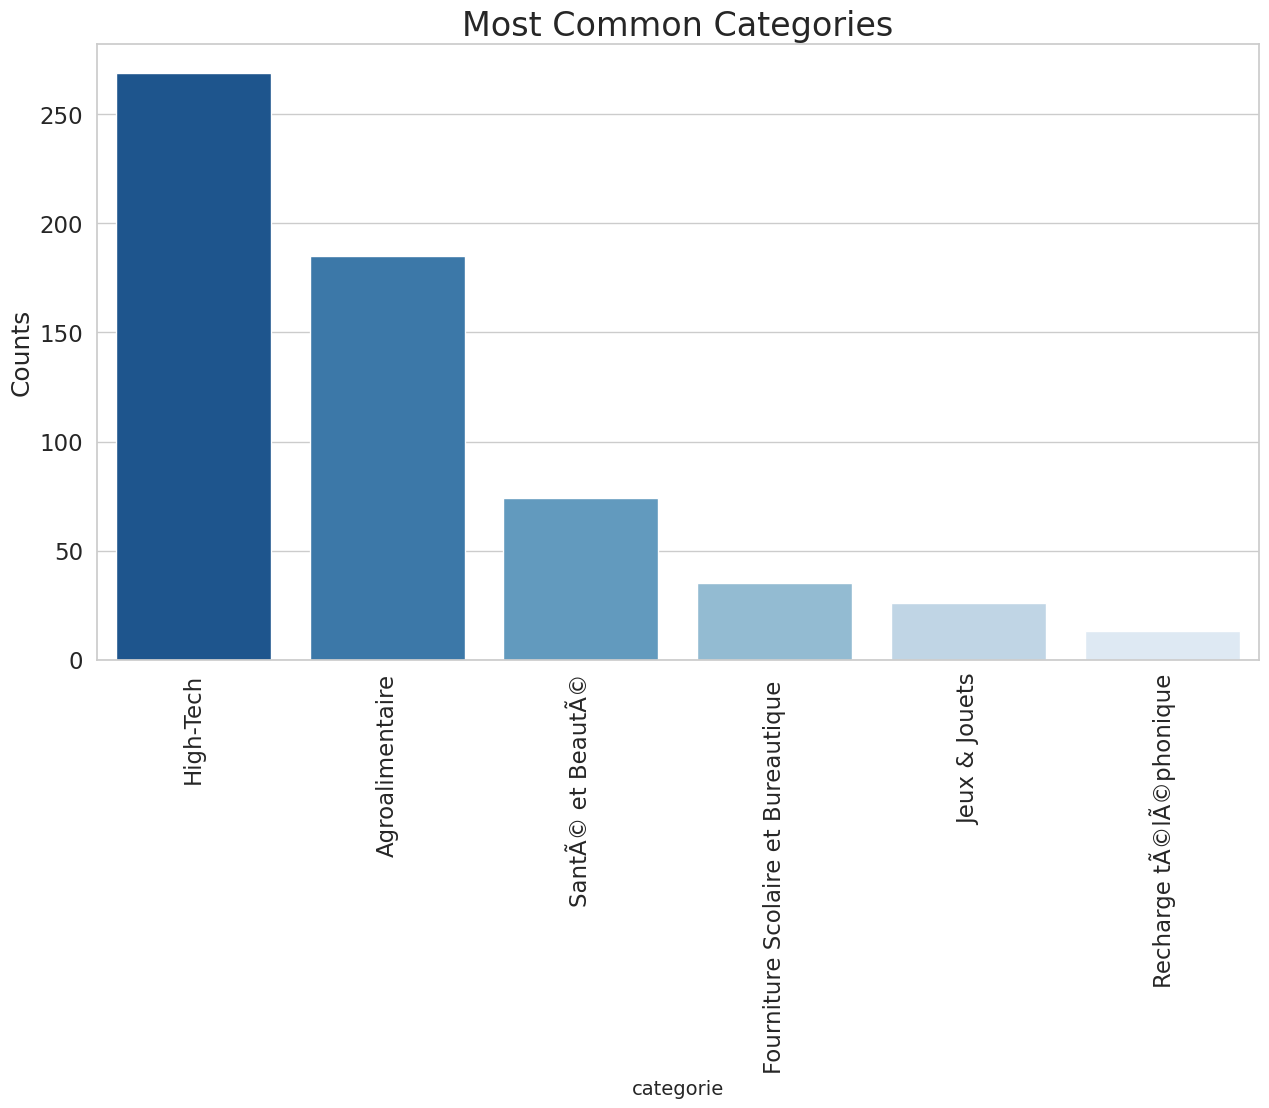

In [197]:
threshold = 500 # A threshold is a value below which all those classes whose count is less than threshold will be treated as 'other' category

plt.figure(figsize=(15,8))
sns.set(font_scale = 1.5)
sns.set_style('whitegrid')

pal = sns.color_palette("Blues_r", len(bar_plot))
rank = bar_plot['count'].argsort().argsort()

sns.barplot(data=bar_plot[:60], x='categorie', y='count', palette=np.array(pal[::-1])[rank])
plt.title("Most Common Categories", fontsize=24)
plt.ylabel('Counts', fontsize=18)
plt.xlabel('categorie', fontsize=14)
plt.xticks(rotation='vertical')
# plt.xticks(color='w') # comment this to view labels
plt.show()

In [196]:
threshold = 20  # taking a lower threshold so can include higher number of classes/categories in consideration, can change this to even lower if want more classes

warnings.filterwarnings('ignore')

main_categories = pd.DataFrame()
main_categories = bar_plot[bar_plot['count'].astype(int) > threshold]
categories = main_categories['categorie'].values
categories = np.append(categories, 'Others')
not_category = []
df2['Others'] = 0

for i in df2.columns[2:]:
    if i not in categories:
        df2['Others'][df2[i] == 1] = 1
        not_category.append(i)

df2.drop(not_category, axis=1, inplace=True)

In [198]:
df2.shape

(602, 8)

In [200]:
df2

,article,descriptions,Agroalimentaire,Fourniture Scolaire et Bureautique,High-Tech,Jeux & Jouets,SantÃ© et BeautÃ©,Others
0,Judy Vitres - Triple Action - 500 ml,<p>Judy Vitres Triple Action excelle dans l&#3...,False,False,False,False,True,0
1,Netto Confort - Essuies-Tout,"<p>Les essuies-tout Netto Confort, livr&eacute...",False,False,False,False,True,0
2,Lilas - DÃ©sodorisant - 3L,<p>Le d&eacute;sodorisant sol de 3 L est un ch...,False,False,False,False,True,0
3,Judy Clorogel - 1.5 L,<p>Judy Clorogel est sp&eacute;cialement con&c...,False,False,False,False,True,0
4,X Clean - DÃ©tachant Ã Tissu - 7in1 250ML,<p>&nbsp;X Clean est un d&eacute;tachant &agra...,False,False,False,False,True,0
...,...,...,...,...,...,...,...,...
597,Rame Papier - 500 feuilles - A4 - 1 TND - Oore...,"<p>Ces 500 feuilles, comprenant 50 vouchers Oo...",False,False,False,False,False,1
598,Rame Papier - 500 feuilles - A4 - 5TND - Ooredoo,"<p>Ces 500 feuilles, comprenant 50 vouchers Oo...",False,False,False,False,False,1
599,Rame Papier - 500 feuilles - A4 - 1 TND - Tuni...,"<p>Ces 500 feuilles, comprenant 50 vouchers Tu...",False,False,False,False,False,1
600,Rame Papier - 500 feuilles - A4 - 5 TND - Tuni...,"<p>Ces 500 feuilles, comprenant 50 vouchers Tu...",False,False,False,False,False,1


In [201]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15,8))
sns.set(font_scale = 1.5)
sns.set_style('whitegrid')

pal = sns.color_palette("Blues_r", len(most_common_cat))
rank = most_common_cat['count'].argsort().argsort()

sns.barplot(most_common_cat['categorie'][:50], most_common_cat['count'][:50])  # Remove the second positional argument

plt.axhline(threshold, ls='--', c='red')
plt.title("Most common categories", fontsize=24)
plt.ylabel('Counts', fontsize=18)
plt.xlabel('Category', fontsize=14)
plt.xticks(rotation='vertical')
plt.show()

TypeError: barplot() takes from 0 to 1 positional arguments but 2 were given

<Figure size 1500x800 with 0 Axes>

In [202]:
boxplot = df2.copy()
boxplot['len'] = df2.descriptions.apply(lambda x: len(x)) # length of descriptions

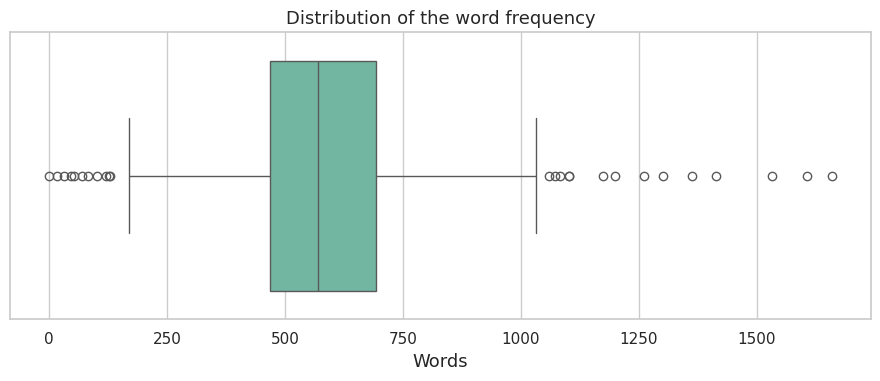

In [203]:
sns.set(style="whitegrid",rc={"font.size":13,"axes.labelsize":13})
plt.figure(figsize=(9, 4))

ax = sns.boxplot(x='len', data=boxplot, orient="h", palette="Set2")
plt.ylabel('')
plt.xlabel('Words')
plt.title("Distribution of the word frequency", fontsize=13)
plt.tight_layout(h_pad=3)

We can observe that most description's length range from 100 too 200 but there are few outliers till 480.

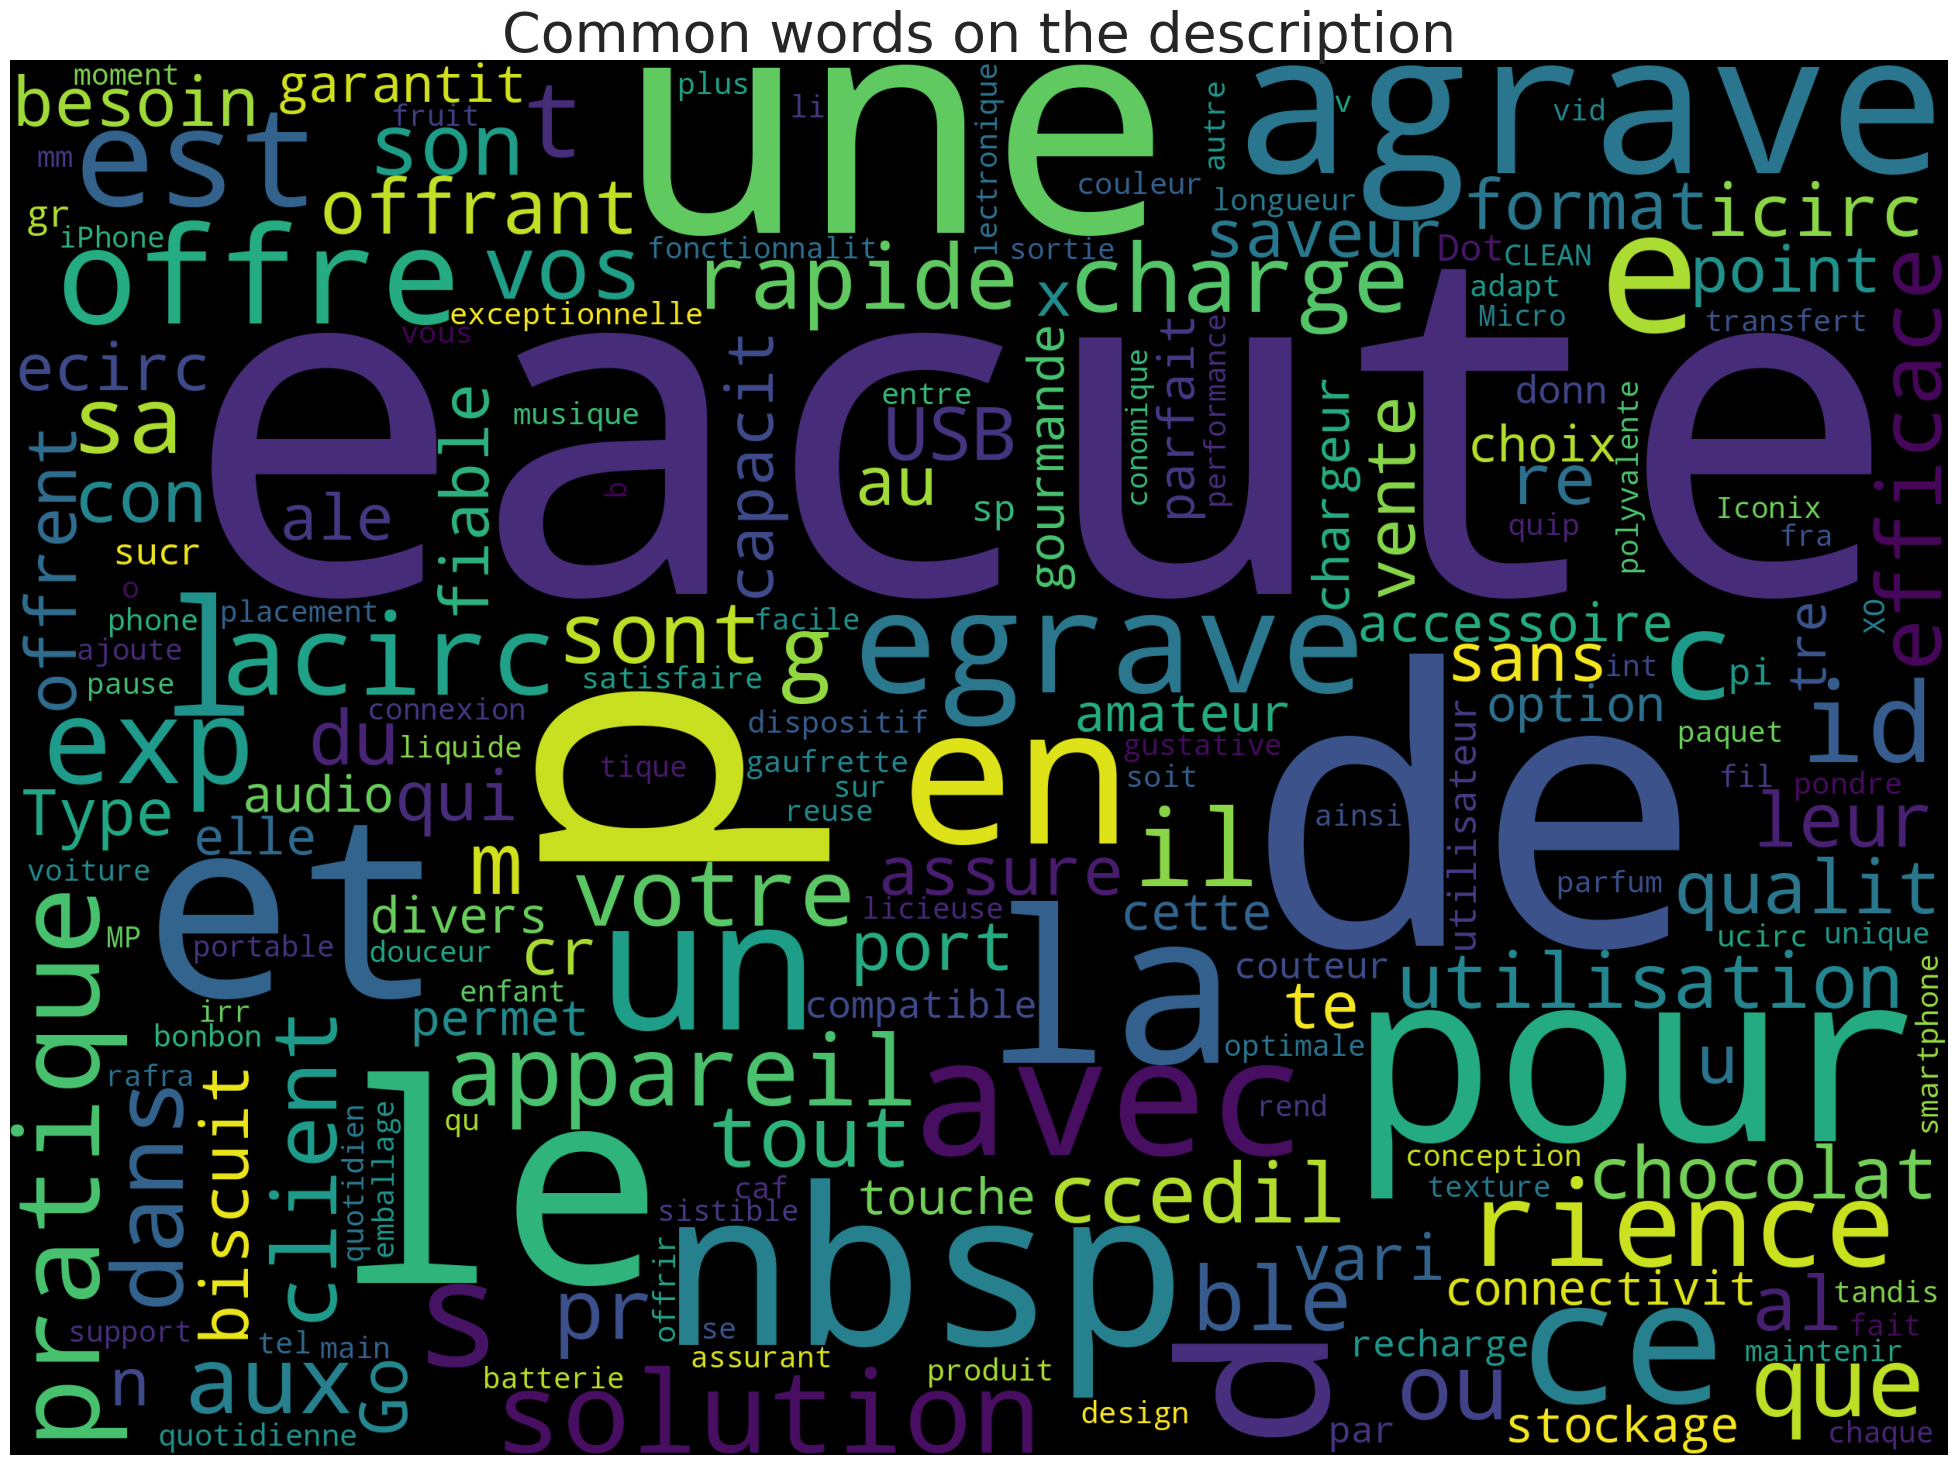

In [204]:
# Visualizing the main context/keywords of the description of products, to better understand the nature of data
from wordcloud import WordCloud,STOPWORDS

plt.figure(figsize=(25,25))
text = df2.descriptions.values
cloud = WordCloud(stopwords=STOPWORDS,
                  background_color='black',
                  collocations=False,
                  width=2500,
                  height=1800
                  ).generate(" ".join(text))
plt.axis('off')
plt.title("Common words on the description",fontsize=40)
plt.imshow(cloud)

In [205]:
# Utility function for data cleaning, natural language processing concepts

def decontract(sentence):
    sentence = str(sentence)
    sentence = re.sub(r"n\'t", " ne", sentence)
    sentence = re.sub(r"\'s", " est", sentence)
    sentence = re.sub(r"\'ve", " a", sentence)
    sentence = re.sub(r"\'m", " suis", sentence)
    sentence = re.sub(r"\'re", " sont", sentence)
    sentence = re.sub(r"\'d", " aurait", sentence)
    sentence = re.sub(r"\'ll", " sera", sentence)
    return sentence

def cleanPunc(sentence):
    sentence = str(sentence)
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    cleaned = cleaned.strip()
    cleaned = cleaned.replace("\n"," ")
    return cleaned

def keepAlpha(sentence):
    sentence = str(sentence)
    alpha_sent = ""
    for word in sentence.split():
        alpha_word = re.sub('[^a-z A-Z]+', '', word)
        alpha_sent += alpha_word
        alpha_sent += " "
    alpha_sent = alpha_sent.strip()
    return alpha_sent

def removeStopWords(sentence):
    sentence = str(sentence)
    global re_stop_words
    return re_stop_words.sub("", sentence)

stopwords= set(['afin', 'ainsi', 'alors', 'au', 'aucuns', 'aussi',
                'autre', 'aux', 'avant', 'avec', 'avoir', 'bon', 'ça',
                'car', 'ce', 'ceci', 'cela', 'celà', 'ces', "c'est",
                'cet', 'cette', 'ceux', 'chaque', 'ci', 'comme', 'comment',
                'dans', 'debut', 'début', 'dedans', 'dehors', 'depuis', 'des',
                'deux', 'devrait', 'doit', 'donc', 'dos', 'droite', 'du',
                "d'un", "d'une", 'egalement', 'elle', 'elles', 'en', 'encore',
                'ensuite', 'es', 'essai', 'est', 'et', 'étaient', 'étais', 'était',
                'étant', 'état', 'etc', 'ete', 'été', 'étée', 'étées', 'êtes', 'étés',
                'étiez', 'étions', 'être', 'eu', 'eux', 'fait', 'faites', 'fois', 'font',
                'force', 'fûmes', 'furent', 'fus', 'fusse', 'fussent', 'fusses', 'fussiez',
                'fussions', 'fut', 'fût', 'fûtes', 'grace', 'grâce', 'haut', 'hors', 'ici', 'il',
                'ils', 'je', 'juste', 'la', 'là', 'le', 'les', 'leur', 'leurs', 'ma', 'maintenant',
                'mais', 'meme', 'même', 'mes', 'mieux', 'mine', 'moins', 'mon', 'mot', 'ni',
                'nommés', 'nos', 'notre', 'nous', 'nouveaux', 'ou', 'où', 'par', 'parce', 'parole',
                'pas', 'personnes', 'peu', 'peut', 'pièce', 'plupart', 'pour', 'pourquoi', 'quand',
                'que', 'quel', 'quelle', 'quelles', 'quels', 'qui', 'sa', 'sans', 'sera', 'serai',
                'seraient', 'serais', 'serait', 'seras', 'serez', 'seriez', 'serions', 'serons', 'seront',
                'ses', 'seulement', 'si', 'sien', 'soi', 'soient', 'sois', 'soit', 'sommes', 'son', 'sont',
                'sous', 'soyez', 'soyons', 'suis', 'sujet', 'sur', 'ta', 'tandis', 'tellement', 'tels',
                'tes', 'ton', 'tous', 'tout', 'toute', 'toutes', 'tres', 'très', 'trop', 'tu', 'un', 'une',
                'valeur', 'voie', 'voient', 'vont', 'vos', 'votre', 'vous', 'vu']
)

re_stop_words = re.compile(r"\b(" + "|".join(stopwords) + ")\\W", re.I)

stemmer = SnowballStemmer("english")
def stemming(sentence):
    sentence = str(sentence)
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence

In [206]:
# Applying data cleaning on description to ignore irrelevant words
df2['descriptions'] = df2['descriptions'].str.lower()
df2['descriptions'] = df2['descriptions'].apply(decontract)
df2['descriptions'] = df2['descriptions'].apply(cleanPunc)
df2['descriptions'] = df2['descriptions'].apply(keepAlpha)
df2['descriptions'] = df2['descriptions'].apply(removeStopWords)
df2['descriptions'] = df2['descriptions'].apply(stemming)

In [207]:
df2.head()

,article,descriptions,Agroalimentaire,Fourniture Scolaire et Bureautique,High-Tech,Jeux & Jouets,SantÃ© et BeautÃ©,Others
0,Judy Vitres - Triple Action - 500 ml,pjudi vitr tripl action excell lentretien vitr...,False,False,False,False,True,0
1,Netto Confort - Essuies-Tout,ples essuiestout netto confort livreacut paque...,False,False,False,False,True,0
2,Lilas - DÃ©sodorisant - 3L,ple deacutesodoris sol de l choix ideacut main...,False,False,False,False,True,0
3,Judy Clorogel - 1.5 L,pjudi clorogel speacutecial conccedilu deacute...,False,False,False,False,True,0
4,X Clean - DÃ©tachant Ã Tissu - 7in1 250ML,pnbspx clean deacutetach agrav tissu innov for...,False,False,False,False,True,0


In [208]:
# Applying data cleaning on product name to ignore irrelevant words
df2['article'] = df2['article'].str.lower()
df2['article'] = df2['article'].apply(decontract)
df2['article'] = df2['article'].apply(cleanPunc)
df2['article'] = df2['article'].apply(keepAlpha)
df2['article'] = df2['article'].apply(removeStopWords)
df2['article'] = df2['article'].apply(stemming)

In [209]:
# creating new column information which is concatenation of product name and description, which stores overall context about any product
df2["information"] = df2["article"] + df2["descriptions"]
df2.head()

,article,descriptions,Agroalimentaire,Fourniture Scolaire et Bureautique,High-Tech,Jeux & Jouets,SantÃ© et BeautÃ©,Others,information
0,judi vitr tripl action ml,pjudi vitr tripl action excell lentretien vitr...,False,False,False,False,True,0,judi vitr tripl action mlpjudi vitr tripl acti...
1,netto confort essuiestout,ples essuiestout netto confort livreacut paque...,False,False,False,False,True,0,netto confort essuiestoutples essuiestout nett...
2,lila dsodoris l,ple deacutesodoris sol de l choix ideacut main...,False,False,False,False,True,0,lila dsodoris lple deacutesodoris sol de l cho...
3,judi clorogel l,pjudi clorogel speacutecial conccedilu deacute...,False,False,False,False,True,0,judi clorogel lpjudi clorogel speacutecial con...
4,x clean dtachant tissu in ml,pnbspx clean deacutetach agrav tissu innov for...,False,False,False,False,True,0,x clean dtachant tissu in mlpnbspx clean deacu...


## Model Creation

Splitting the data into train/test set

In [210]:
X_train, X_test, y_train, y_test = train_test_split(df2['information'],
                                                    df2[df2.columns[2:-1]],
                                                    test_size=0.3,
                                                    random_state=0,
                                                    shuffle=True)

In [211]:
vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,3), norm='l2') # Using a tf-idf weighting scheme rather than normal boolean weights for better performance
vectorizer.fit(X_train) # Reference : https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

In [212]:
print("X_train shape : ",X_train.shape)
print("X_test shape : ",X_test.shape)

X_train shape :  (421, 30258)
X_test shape :  (181, 30258)


To solve multi-label problems, we mainly have approaches:


1.   **Binary classification** :  This strategy divides the problem into several independent binary classification tasks. It resembles the one-vs-rest method, but each classifier deals with a single label, which means the algorithm assumes they are mutually exclusive.
2.  **Multi-class classification** : The labels are combined into one big binary classifier called powerset. For instance, having the targets A, B, and C, with 0 or 1 as outputs, we have A B C -> [0 1 0], while the binary classification transformation treats it as A B C -> [0] [1] [0].

We will first use the Binary classification technique.


In [213]:
LR_pipeline = Pipeline([('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=-1))])
# one-vs-all, this strategy consists in fitting one classifier per class. For each classifier, the class is fitted against all the other classes. In addition to its computational efficiency (only n_classes classifiers are needed), one advantage of this approach is its interpretability. Since each class is represented by one and one classifier only, it is possible to gain knowledge about the class by inspecting its corresponding classifier. This is the most commonly used strategy for multiclass classification and is a fair default choice.
# Reference : https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html

# sag : Algorithm to use in the optimization problem, ‘saga’ also supports ‘elasticnet’ penalty  Reference : https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
# n_jobs : The number of jobs to use for the computation: the n_classes one-vs-rest problems are computed in parallel. Reference : https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html
# clf : name given to the Pipeline

accuracy = 0
auc = 0
modelNumber = 1
for category in df2.columns[2:-1]:
    LR_pipeline.fit(X_train, y_train[category]) # Training logistic regression model on train data
    prediction = LR_pipeline.predict(X_test)    # calculating predictions
    acc = accuracy_score(y_test[category], prediction)
    au = roc_auc_score(y_test[category],prediction)
    accuracy = accuracy + acc
    auc = auc + au
    print('CATEGORY => {} '.format(category),'AUC ROC score => {}'.format(au)," Accuracy => {}".format(acc))
    filename = str(modelNumber)+"_model.sav"
    joblib.dump(LR_pipeline, filename)          # saving individual classifiers for later use
    modelNumber += 1
print("-------------------------------------------------------------------------------------------------------------------------------")
print('Test averaged Accuracy => {}'.format(accuracy/len(df2.columns[2:-1])))
print('Test averaged AUC ROC Score => {}'.format(auc/len(df2.columns[2:-1])))

CATEGORY => Agroalimentaire  AUC ROC score => 0.9479166666666667  Accuracy => 0.9723756906077348
CATEGORY => Fourniture Scolaire et Bureautique   AUC ROC score => 0.5  Accuracy => 0.9392265193370166
CATEGORY => High-Tech  AUC ROC score => 0.9879518072289157  Accuracy => 0.988950276243094
CATEGORY => Jeux & Jouets  AUC ROC score => 0.5  Accuracy => 0.9558011049723757
CATEGORY => SantÃ© et BeautÃ©  AUC ROC score => 0.5416666666666666  Accuracy => 0.8784530386740331
CATEGORY => Others  AUC ROC score => 0.5  Accuracy => 0.9613259668508287
-------------------------------------------------------------------------------------------------------------------------------
Test averaged Accuracy => 0.949355432780847
Test averaged AUC ROC Score => 0.6629225234270415


In [214]:
# Api for category prediction
def categoryPrediction(name,description):
  # performing necessary data cleaning operations od product name and description
  name = name.lower()
  name = decontract(name)
  name = cleanPunc(name)
  name = keepAlpha(name)
  name = removeStopWords(name)
  name = stemming(name)

  description = description.lower()
  description = decontract(description)
  description = cleanPunc(description)
  description = keepAlpha(description)
  description = removeStopWords(description)
  description = stemming(description)

  information = name + description  # creating information text
  X_api = vectorizer.transform([information]) # transforming using already trained vectorizing transformer

  # LR_pipeline = Pipeline([('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=-1))])
  accuracy = 0
  modelNumber = 1
  for category in df2.columns[2:-1]:
    # LR_pipeline.fit(X_train, y_train[category])
    filename = str(modelNumber)+"_model.sav"
    modelNumber += 1
    LR_pipeline = joblib.load(filename) # loading already saved model

    # calculating test accuracy
    prediction = LR_pipeline.predict(X_api)
    if prediction==1:
      print('CATEGORY {}'.format(category)) # if models predicts true print that category

In [215]:
name = "Samsung - Galaxy S7 32GB - Black Onyx (Sprint)"
description = "Qualcomm Snapdragon 820 MSM8996 2.2GHz quad-core processorAndroid 6.0 Marshmallow operating system4G mobile hotspot capability with support for up to 10 devicesWiFi Capable 802.11 a/b/g/n/ac5.1\" WQHD touch-screen displayBluetooth 4.2"
categoryPrediction(name,description)

CATEGORY High-Tech


In [216]:
name = "Sidi Ali - Thon - 140 g"
description = "<p>Le thon Sidi Ali, propos&eacute; en bo&icirc;te de conserve de 140 grammes, est une option d&eacute;licieuse et pratique pour les amateurs de thon. Avec son conditionnement en bo&icirc;te de 140 grammes, ce thon Sidi Ali est facile &agrave; utiliser dans une vari&eacute;t&eacute; de recettes, que ce soit pour des salades, des sandwichs, ou des plats cuisin&eacute;s. La qualit&eacute; du thon Sidi Ali assure une saveur d&eacute;licieuse et une texture tendre, ajoutant une touche nutritive &agrave; vos repas.</p>"
categoryPrediction(name,description)

CATEGORY Agroalimentaire


In [217]:
# Test for API
name = "Ooredoo -  5 TND"
description = "<p>C&#39;est un support de recharge pour les clients Tunisie T&eacute;l&eacute;com. Les vouchers pr&eacute;-d&eacute;coup&eacute;s offrent une solution pratique pour les transactions de recharge de cr&eacute;dit, permettant aux clients d&#39;obtenir rapidement et facilement des cr&eacute;dits t&eacute;l&eacute;phoniques pr&eacute;pay&eacute;s. Il est possible de recevoir un minimum de 50 tickets pr&eacute;-imprim&eacute;s et pr&eacute;-d&eacute;coup&eacute;s, qui seront livr&eacute;s directement &agrave; l&#39;adresse de votre point de vente.</p>"
categoryPrediction(name,description)

In [218]:
# Test for API
name = "Tunisie Telecom -  1 TND"
description = "<p>C&#39;est un support de recharge pour les clients Tunisie T&eacute;l&eacute;com. Les vouchers pr&eacute;-d&eacute;coup&eacute;s offrent une solution pratique pour les transactions de recharge de cr&eacute;dit, permettant aux clients d&#39;obtenir rapidement et facilement des cr&eacute;dits t&eacute;l&eacute;phoniques pr&eacute;pay&eacute;s. Il est possible de recevoir un minimum de 50 tickets pr&eacute;-imprim&eacute;s et pr&eacute;-d&eacute;coup&eacute;s, qui seront livr&eacute;s directement &agrave; l&#39;adresse de votre point de vente.</p>"
categoryPrediction(name,description)

Other models worth trying are Naive Bayes, SVC, Random Forest.

# Deep Learning Based Models

Follows the Multi-class classification based model.

In [219]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [220]:
df2['information']

0      judi vitr tripl action mlpjudi vitr tripl acti...
1      netto confort essuiestoutples essuiestout nett...
2      lila dsodoris lple deacutesodoris sol de l cho...
3      judi clorogel lpjudi clorogel speacutecial con...
4      x clean dtachant tissu in mlpnbspx clean deacu...
                             ...                        
597    rame papier feuill a tnd ooredoopces feuill co...
598    rame papier feuill a tnd ooredoopces feuill co...
599    rame papier feuill a tnd tunisi tlcompces feui...
600    rame papier feuill a tnd tunisi tlcompces feui...
601    papier thermiqu rouleaux mmplot de papier ther...
Name: information, Length: 602, dtype: object

In [221]:
tokenizer = Tokenizer(num_words=5000, lower=True) # lower : boolean. Whether to convert the texts to lowercase. , num_words : the maximum number of words to keep, based on word frequency.
tokenizer.fit_on_texts(df2['information']) # encoding words of information to integers, Updates internal vocabulary based on a list of sequences.
sequences = tokenizer.texts_to_sequences(df2['information'])
x = pad_sequences(sequences, maxlen=500) # provide tagging to make each sequence of length 500

In [222]:
x.shape

(602, 500)

In [223]:
# Splitting dataset in train/test set
X_train, X_test, y_train, y_test = train_test_split(x, df2[df2.columns[2:-1]],
                                                    test_size=0.3,
                                                    random_state=0)

In [224]:
most_common_cat['class_weight'] = len(most_common_cat) / most_common_cat['count']
class_weight = {}
most_common_cat.head()

,categorie,count,class_weight
0,High-Tech,269,0.011152
1,Agroalimentaire,185,0.016216
2,Others,148,0.020270


In [225]:
categories # categories in which our results will belong to

array(['High-Tech', 'Agroalimentaire', 'SantÃ© et BeautÃ©',
       'Fourniture Scolaire et Bureautique ', 'Jeux & Jouets', 'Others'],
      dtype=object)

In [226]:
num_classes = y_train.shape[1]
max_words = len(tokenizer.word_index) + 1
maxlen = 500

In [227]:
num_classes # number of categories/classes

6

In [228]:
max_words # max words/ total vocab + 1

3330

In [229]:
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Embedding, GlobalMaxPool1D, Dropout
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import tensorflow as tf

model = Sequential()
model.add(Embedding(max_words, 300, input_length=maxlen)) # Turns positive integers (indexes) into dense vectors of fixed size, input_dim = 500, output_dim = 300
#model.add(Dropout(0.2))
model.add(tf.keras.layers.Dense(300, activation='relu'))
model.add(GlobalMaxPool1D())
model.add(Dense(num_classes, activation='sigmoid'))

model.compile(optimizer=Adam(0.015), loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])
callbacks = [
    ReduceLROnPlateau(), # Reduce learning rate when a metric has stopped improving
    #EarlyStopping(patience=10),
    ModelCheckpoint(filepath='model-neural-net.h5', save_best_only=True)
]

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 300)          999000    
                                                                 
 dense (Dense)               (None, 500, 300)          90300     
                                                                 
 global_max_pooling1d (Glob  (None, 300)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense_1 (Dense)             (None, 6)                 1806      
                                                                 
Total params: 1091106 (4.16 MB)
Trainable params: 1091106 (4.16 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


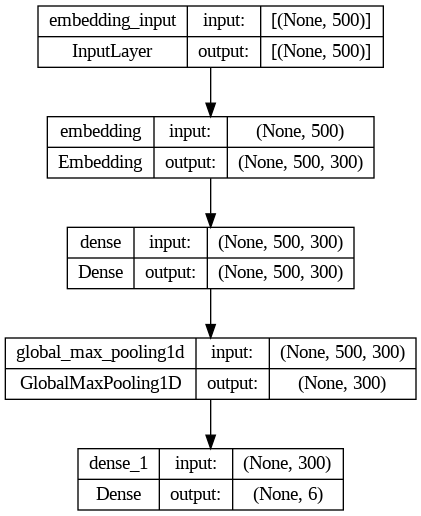

In [230]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_nn_plot.png', show_shapes=True, show_layer_names=True)

In [243]:
# Check data types of X_train and y_train

# Convert boolean values to numeric if necessary
if type(X_train) == bool or type(y_train) == bool:
    X_train = X_train.astype(int)
    y_train = y_train.astype(int).to_numpy()
print(type(X_train))
print(type(y_train.to_numpy()))




<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [248]:
    y_train = y_train.astype(int)
    y_train

,Agroalimentaire,Fourniture Scolaire et Bureautique,High-Tech,Jeux & Jouets,SantÃ© et BeautÃ©,Others
222,1,0,0,0,0,0
134,1,0,0,0,0,0
344,0,0,1,0,0,0
583,0,0,1,0,0,0
404,0,0,1,0,0,0
...,...,...,...,...,...,...
277,1,0,0,0,0,0
9,0,0,0,0,1,0
359,0,0,1,0,0,0
192,1,0,0,0,0,0


In [249]:
# Fit the model with the corrected data
history = model.fit(X_train, y_train,
                      # Pass a valid class_weight dictionary or remove this argument if not needed
                    epochs=30,
                    batch_size=32,
                    validation_split=0.3,
                    callbacks=callbacks)

Epoch 1/30
10/10 [==============================] - 7s 425ms/step - loss: 0.2960 - auc: 0.8828 - val_loss: 0.1626 - val_auc: 0.9421 - lr: 0.0150
Epoch 2/30
10/10 [==============================] - 3s 315ms/step - loss: 0.0520 - auc: 0.9899 - val_loss: 0.0560 - val_auc: 0.9952 - lr: 0.0150
Epoch 3/30
10/10 [==============================] - 3s 325ms/step - loss: 0.0039 - auc: 1.0000 - val_loss: 0.0627 - val_auc: 0.9899 - lr: 0.0150
Epoch 4/30
10/10 [==============================] - 2s 225ms/step - loss: 9.1260e-04 - auc: 1.0000 - val_loss: 0.0618 - val_auc: 0.9941 - lr: 0.0150
Epoch 5/30
10/10 [==============================] - 2s 222ms/step - loss: 1.1615e-04 - auc: 1.0000 - val_loss: 0.0652 - val_auc: 0.9944 - lr: 0.0150
Epoch 6/30
10/10 [==============================] - 2s 225ms/step - loss: 4.1333e-05 - auc: 1.0000 - val_loss: 0.0692 - val_auc: 0.9905 - lr: 0.0150
Epoch 7/30
10/10 [==============================] - 2s 222ms/step - loss: 2.6126e-05 - auc: 1.0000 - val_loss: 0.0710 

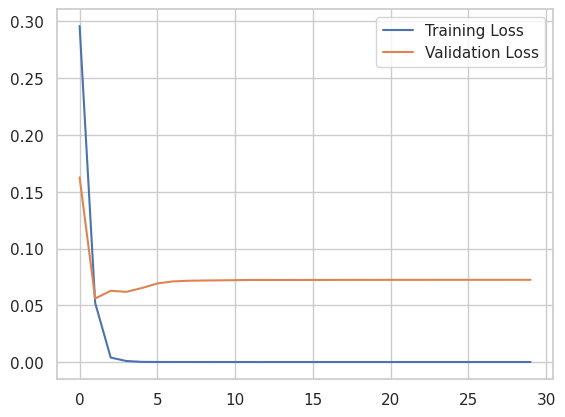

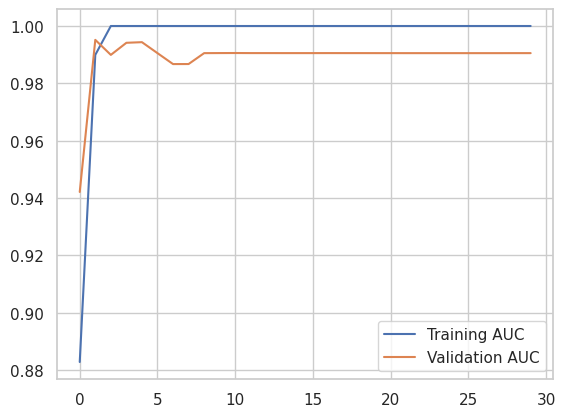

In [250]:
# Plotting losses wrt epochs(time)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()
# Plotting accuracy wrt epochs(time)
plt.plot(history.history["auc"], label="Training AUC")
plt.plot(history.history["val_auc"], label="Validation AUC")
plt.legend()
plt.show()

In [252]:
    y_test = y_test.astype(int)

metrics = model.evaluate(X_test, y_test)
print("{}: {}".format(model.metrics_names[1], metrics[1]))

6/6 [==============================] - 1s 98ms/step - loss: 0.0955 - auc: 0.9867
auc: 0.9867219924926758


In [253]:
classes = [col for col in df2.columns]
classes = classes[2:-1]
classes

['Agroalimentaire',
 'Fourniture Scolaire et Bureautique ',
 'High-Tech',
 'Jeux & Jouets',
 'SantÃ© et BeautÃ©',
 'Others']

In [254]:
import operator
# Utility function to get predictions using Neural Net model
def categoryPredictionNN(name,description):
  # Data cleaning process
  name = name.lower()
  name = decontract(name)
  name = cleanPunc(name)
  name = keepAlpha(name)
  name = removeStopWords(name)
  name = stemming(name)

  description = description.lower()
  description = decontract(description)
  description = cleanPunc(description)
  description = keepAlpha(description)
  description = removeStopWords(description)
  description = stemming(description)

  information = name + description
  # necessary data preprocessing steps
  sequences = tokenizer.texts_to_sequences([information])
  x = pad_sequences(sequences, maxlen=500)
  prediction = model.predict(x)
  predScores = [score for pred in prediction for score in pred]
  predDict = {}
  for cla,score in zip(classes,predScores):
    predDict[cla] = score

  return sorted(predDict.items(), key=operator.itemgetter(1),reverse=True)[:10] # return top 10 results

In [255]:
name = "<ul><li>Thon - Sidi Ali</li><li>Contenance: 140 g&nbsp;</li><li>Format: En boite de conserve</li></ul>"
description = "Fits most wrist sizesCompatible with most Apple&#174; iOS and Android cell phones22mm stainless steel bandWater-resistant designAt-a-glance notifications"
prediction = categoryPredictionNN(name,description)
prediction

1/1 [==============================] - 0s 121ms/step


[('High-Tech', 0.5568285),
 ('Fourniture Scolaire et Bureautique ', 0.11638864),
 ('Others', 0.019825773),
 ('SantÃ© et BeautÃ©', 0.0191649),
 ('Jeux & Jouets', 0.00371798),
 ('Agroalimentaire', 0.00067217025)]

In [256]:
name = "Calculatrice GM - DM-1200 V "
description = "<p>&nbsp;</p><p>Cette calculatrice&nbsp;aliment&eacute;e par piles et fabriqu&eacute;e en plastique, offre une solution pratique pour une vari&eacute;t&eacute; de calculs math&eacute;matiques et financiers. Avec des dimensions de 7,28 pouces en longueur et 5,71 pouces en largeur, elle est con&ccedil;ue pour &ecirc;tre portable et facile &agrave; utiliser dans divers contextes. Son utilit&eacute; se manifeste dans sa capacit&eacute; &agrave; effectuer des calculs de base ainsi que des op&eacute;rations math&eacute;matiques avanc&eacute;es, ce qui en fait un outil polyvalent pour les besoins quotidiens &agrave; la maison, &agrave; l&#39;&eacute;cole ou au travail. Aliment&eacute;e par piles, elle garantit une autonomie, tandis que son mat&eacute;riau en plastique lui conf&egrave;re l&eacute;g&egrave;ret&eacute; et praticit&eacute;.</p>"
prediction = categoryPredictionNN(name,description)
prediction

1/1 [==============================] - 0s 40ms/step


[('Fourniture Scolaire et Bureautique ', 0.048278604),
 ('High-Tech', 0.00088570535),
 ('SantÃ© et BeautÃ©', 7.492056e-05),
 ('Agroalimentaire', 5.955419e-05),
 ('Jeux & Jouets', 3.229867e-05),
 ('Others', 1.13221995e-05)]

In [ ]:
name = "Duracell - AAA Batteries (4-Pack)"
description = "Compatible with select electronic devices; AAA size; DURALOCK Power Preserve technology; 4-pack"
prediction = categoryPredictionNN(name,description)
prediction

[('Others', 0.58975905),
 ('Household Batteries', 0.45791835),
 ('Housewares', 0.42572102),
 ('Connected Home & Housewares', 0.2705805),
 ('Cell Phone Batteries & Power', 0.23732899),
 ('Cell Phone Accessories', 0.12389457),
 ('Cell Phones', 0.10485156),
 ('Computers & Tablets', 0.09228797),
 ('Computer Accessories & Peripherals', 0.08647067),
 ('Portable Chargers/Power Packs', 0.0818246)]

In [ ]:
name = "Keurig - Green Mountain Coffee Organic Ethiopia Yirgacheffe K-Cups (16-Pack)"
description = "Compatible with Keurig single-serve K-Cup and 2.0 coffee brewers; notes of citrus and ginger; 16-pack"
prediction = categoryPredictionNN(name,description)
prediction

[('Appliances', 1.0),
 ('Coffee, Tea & Espresso', 0.99999785),
 ('Small Kitchen Appliances', 0.9999968),
 ('Coffee Pods', 0.45578045),
 ('Coffee Pods & Beans', 0.45359275),
 ('Coffee Makers', 0.37891108),
 ('Others', 0.33263376),
 ('Multi-Cup Coffee Makers', 0.0155124655),
 ('Electric Griddles & Hotplates', 0.0005977321),
 ('Food Preparation Utensils', 4.417213e-05)]

In [ ]:
name = "Kung Fu Panda: Showdown of Legendary Legends - Xbox One"
description = "Jump into an all-out brawl for honor, glory and legend status"
prediction = categoryPredictionNN(name,description)
prediction

[('Video Games', 0.9999708),
 ('Xbox One', 0.9522117),
 ('Xbox One Games', 0.9148641),
 ('Xbox 360', 0.15184803),
 ('Others', 0.06697376),
 ('Xbox 360 Games', 0.03130113),
 ('PlayStation 4', 0.013806573),
 ('Video Game Accessories', 0.013297716),
 ('PC Gaming', 0.008662028),
 ('Computer Accessories & Peripherals', 0.00067955005)]

## Conv Net Model

In [ ]:
from keras.layers import Dense, Activation, Embedding, Flatten, GlobalMaxPool1D, Dropout, Conv1D

model = Sequential()
model.add(Embedding(max_words, 300, input_length=maxlen))
model.add(Dropout(0.2))
model.add(Conv1D(300, 3, padding='valid', activation='relu', strides=1))
model.add(GlobalMaxPool1D()) # This layer creates a convolution kernel that is convolved with the layer input over a single spatial (or temporal) dimension to produce a tensor of outputs.
model.add(Dropout(0.2))
model.add(Dense(num_classes))
model.add(Activation('sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])

callbacks = [
    ReduceLROnPlateau(),
    ModelCheckpoint(filepath='model-conv1d.h5', save_best_only=True)
]

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 300)          11109300  
_________________________________________________________________
dropout (Dropout)            (None, 500, 300)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 498, 300)          270300    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 300)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 269)               80969     
_________________________________________________________________
activation (Activation)      (None, 269)              

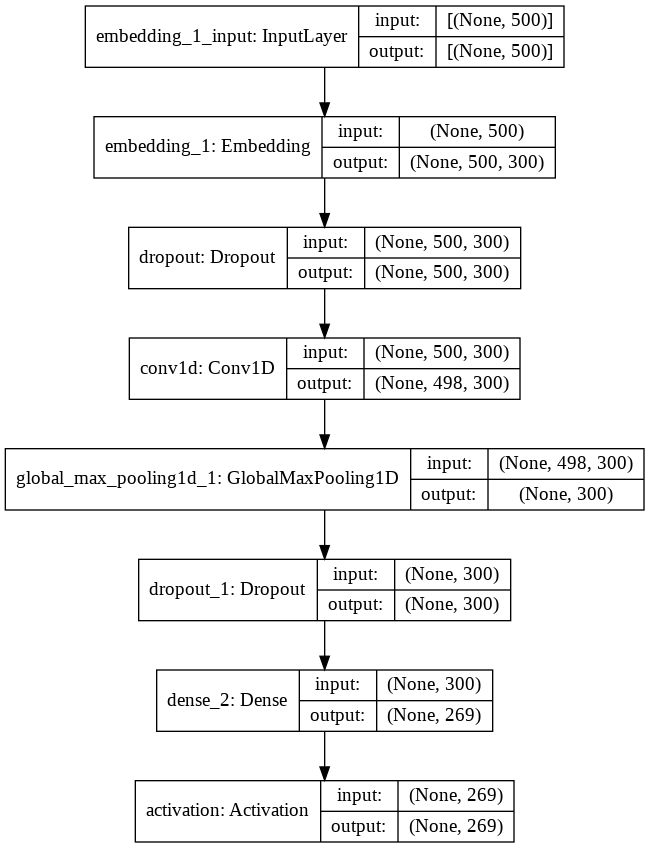

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_cnn_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
history = model.fit(X_train, y_train,
                    class_weight=class_weight,
                    epochs=30,
                    batch_size=32,
                    validation_split=0.3,
                    callbacks=callbacks)

Epoch 1/30
791/791 [==============================] - 66s 49ms/step - loss: 0.0438 - auc_1: 0.9125 - val_loss: 0.0171 - val_auc_1: 0.9890
Epoch 2/30
791/791 [==============================] - 38s 48ms/step - loss: 0.0140 - auc_1: 0.9894 - val_loss: 0.0109 - val_auc_1: 0.9936
Epoch 3/30
791/791 [==============================] - 38s 48ms/step - loss: 0.0097 - auc_1: 0.9939 - val_loss: 0.0090 - val_auc_1: 0.9941
Epoch 4/30
791/791 [==============================] - 38s 48ms/step - loss: 0.0076 - auc_1: 0.9958 - val_loss: 0.0082 - val_auc_1: 0.9938
Epoch 5/30
791/791 [==============================] - 38s 48ms/step - loss: 0.0063 - auc_1: 0.9969 - val_loss: 0.0079 - val_auc_1: 0.9934
Epoch 6/30
791/791 [==============================] - 38s 48ms/step - loss: 0.0054 - auc_1: 0.9976 - val_loss: 0.0079 - val_auc_1: 0.9930
Epoch 7/30
791/791 [==============================] - 38s 48ms/step - loss: 0.0046 - auc_1: 0.9983 - val_loss: 0.0078 - val_auc_1: 0.9918
Epoch 8/30
791/791 [==============

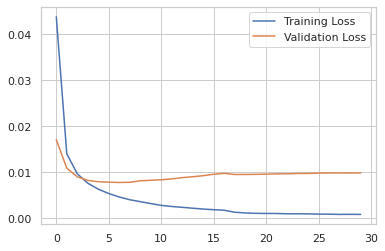

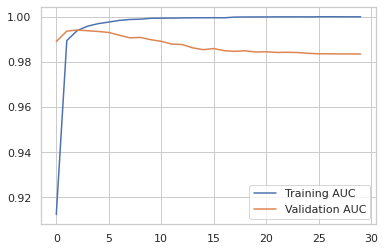

In [ ]:
# Plotting losses wrt epochs(time)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()
# Plotting accuracy wrt epochs(time)
plt.plot(history.history["auc_1"], label="Training AUC")
plt.plot(history.history["val_auc_1"], label="Validation AUC")
plt.legend()
plt.show()

In [ ]:
metrics = model.evaluate(X_test, y_test)
print("{}: {}".format(model.metrics_names[1], metrics[1]))

485/485 [==============================] - 6s 13ms/step - loss: 0.0098 - auc_1: 0.9836
auc_1: 0.9835618734359741


In [ ]:
name = "Motorola - Moto 360 2nd Generation Men's Smartwatch 42mm Stainless Steel - Gold Stainless Steel"
description = "Fits most wrist sizesCompatible with most Apple&#174; iOS and Android cell phones22mm stainless steel bandWater-resistant designAt-a-glance notifications"
prediction = categoryPredictionNN(name,description)
prediction

[('Cell Phones', 0.9999945),
 ('Cell Phone Accessories', 0.99997914),
 ('Others', 0.9999229),
 ('Smartwatches & Accessories', 0.9998704),
 ('Smartwatch Accessories', 0.0002902599),
 ('iPhone Accessories', 8.241499e-05),
 ('Smartwatch Bands', 1.3853268e-05),
 ('Adapters, Cables & Chargers', 8.2079305e-06),
 ('Pre-Owned Games', 7.2256735e-06),
 ('Wall Chargers & Power Adapters', 3.476159e-06)]

In [ ]:
name = "Samsung - Galaxy S7 32GB - Black Onyx (Sprint)"
description = "Qualcomm Snapdragon 820 MSM8996 2.2GHz quad-core processorAndroid 6.0 Marshmallow operating system4G mobile hotspot capability with support for up to 10 devicesWiFi Capable 802.11 a/b/g/n/ac5.1\" WQHD touch-screen displayBluetooth 4.2"
prediction = categoryPredictionNN(name,description)
prediction

[('Cell Phones', 0.99995446),
 ('All Cell Phones with Plans', 0.9997551),
 ('Unlocked Cell Phones', 0.0048751077),
 ('All Unlocked Cell Phones', 0.0009406521),
 ('Others', 0.0009243891),
 ('Memory Cards', 9.0651076e-05),
 ('Name Brands', 2.2462818e-05),
 ('Cell Phone Accessories', 4.764526e-06),
 ('iPhone Accessories', 3.8404423e-06),
 ('Video Games', 2.4172457e-06)]

In [ ]:
name = "Duracell - AAA Batteries (4-Pack)"
description = "Compatible with select electronic devices; AAA size; DURALOCK Power Preserve technology; 4-pack"
prediction = categoryPredictionNN(name,description)
prediction

[('Others', 0.99999225),
 ('Household Batteries', 0.99999094),
 ('Connected Home & Housewares', 0.9999871),
 ('Housewares', 0.9999833),
 ('Household Essentials', 0.00041118963),
 ('Musical Instrument Accessories', 7.030809e-05),
 ('Outdoor Living', 2.5869182e-05),
 ('Patio Furniture & Decor', 2.269643e-05),
 ('Furniture & Decor', 1.2533402e-05),
 ('Home Audio', 8.586917e-06)]

In [ ]:
name = "Keurig - Green Mountain Coffee Organic Ethiopia Yirgacheffe K-Cups (16-Pack)"
description = "Compatible with Keurig single-serve K-Cup and 2.0 coffee brewers; notes of citrus and ginger; 16-pack"
prediction = categoryPredictionNN(name,description)
prediction

[('Appliances', 1.0),
 ('Coffee, Tea & Espresso', 0.99999976),
 ('Small Kitchen Appliances', 0.99998677),
 ('Coffee Pods & Beans', 0.98284125),
 ('Coffee Pods', 0.97692025),
 ('Others', 0.12987375),
 ('Coffee Makers', 9.317827e-05),
 ('Pre-Owned Games', 4.7141268e-05),
 ('Toys, Games & Drones', 7.1472828e-06),
 ('Blenders & Juicers', 2.1098922e-06)]

In [ ]:
name = "Kung Fu Panda: Showdown of Legendary Legends - Xbox One"
description = "Jump into an all-out brawl for honor, glory and legend status"
prediction = categoryPredictionNN(name,description)
prediction

[('Video Games', 1.0),
 ('Xbox One', 0.9999716),
 ('Xbox One Games', 0.9998442),
 ('Others', 0.0008864943),
 ('PlayStation 4', 0.0004631719),
 ('Pre-Owned Games', 0.00024294778),
 ('PS4 Games', 0.00015946868),
 ('Toys to Life', 4.5421897e-05),
 ('Xbox 360', 2.801538e-05),
 ('PC Gaming', 1.3896777e-05)]

## LSTM + Glove Model

In [ ]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
# Importing glove file
glove_file = open('drive/My Drive/datasets/glove.6B.100d.txt', encoding="utf8") # Reference : https://nlp.stanford.edu/projects/glove/
# GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((max_words, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
from keras.layers import Input
from keras.layers import Flatten, LSTM
from keras.models import Model

deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(max_words, 100, weights=[embedding_matrix], trainable=False)(deep_inputs)
dropout_embedding_layer = Dropout(0.2)(embedding_layer)
LSTM_Layer_1 = LSTM(300)(dropout_embedding_layer)
dropout_LSTM_Layer_1 =  Dropout(0.2)(LSTM_Layer_1)
dense_layer_1 = Dense(num_classes, activation='sigmoid')(dropout_LSTM_Layer_1)
model = Model(inputs=deep_inputs, outputs=dense_layer_1)

callbacks = [
    ReduceLROnPlateau(),
    ModelCheckpoint(filepath='model-LSTM.h5', save_best_only=True)
]

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.AUC()])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 500, 100)          3703100   
_________________________________________________________________
dropout_4 (Dropout)          (None, 500, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 300)               481200    
_________________________________________________________________
dropout_5 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 269)               80969     
Total params: 4,265,269
Trainable params: 562,169
Non-trainable params: 3,703,100
___________________________________________

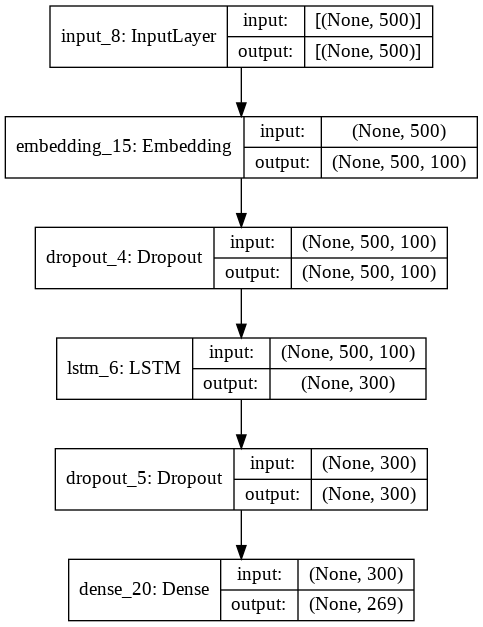

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_LSTM_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
history = model.fit(X_train, y_train.values,
                    class_weight=class_weight,
                    batch_size=32,
                    epochs=30,
                    validation_split=0.3,
                    callbacks=callbacks)

Epoch 1/30
791/791 [==============================] - 132s 163ms/step - loss: 0.0595 - auc_3: 0.8077 - val_loss: 0.0475 - val_auc_3: 0.8666
Epoch 2/30
791/791 [==============================] - 128s 162ms/step - loss: 0.0442 - auc_3: 0.8947 - val_loss: 0.0405 - val_auc_3: 0.9230
Epoch 3/30
791/791 [==============================] - 128s 162ms/step - loss: 0.0374 - auc_3: 0.9354 - val_loss: 0.0330 - val_auc_3: 0.9559
Epoch 4/30
791/791 [==============================] - 127s 161ms/step - loss: 0.0336 - auc_3: 0.9489 - val_loss: 0.0435 - val_auc_3: 0.8997
Epoch 5/30
791/791 [==============================] - 128s 162ms/step - loss: 0.0323 - auc_3: 0.9552 - val_loss: 0.0276 - val_auc_3: 0.9705
Epoch 6/30
791/791 [==============================] - 127s 161ms/step - loss: 0.0271 - auc_3: 0.9700 - val_loss: 0.0244 - val_auc_3: 0.9757
Epoch 7/30
791/791 [==============================] - 128s 162ms/step - loss: 0.0239 - auc_3: 0.9761 - val_loss: 0.0216 - val_auc_3: 0.9816
Epoch 8/30
791/791 [

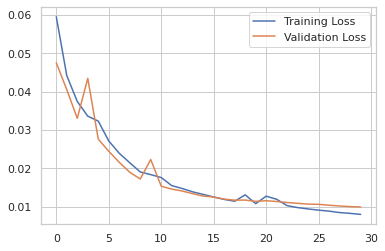

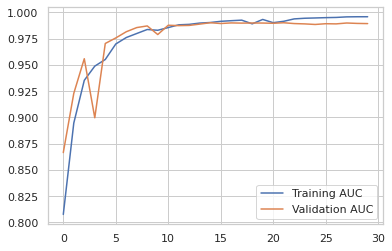

In [ ]:
# Plotting losses wrt epochs(time)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()
# Plotting accuracy wrt epochs(time)
plt.plot(history.history["auc_3"], label="Training AUC")
plt.plot(history.history["val_auc_3"], label="Validation AUC")
plt.legend()
plt.show()

In [ ]:
metrics = model.evaluate(X_test, y_test)
print("{}: {}".format(model.metrics_names[1], metrics[1]))

485/485 [==============================] - 24s 50ms/step - loss: 0.0100 - auc_3: 0.9892
auc_3: 0.9891976118087769


In [ ]:
name = "Motorola - Moto 360 2nd Generation Men's Smartwatch 42mm Stainless Steel - Gold Stainless Steel"
description = "Fits most wrist sizesCompatible with most Apple&#174; iOS and Android cell phones22mm stainless steel bandWater-resistant designAt-a-glance notifications"
prediction = categoryPredictionNN(name,description)
prediction

[('Cell Phones', 0.9937966),
 ('Smartwatches & Accessories', 0.99336255),
 ('Cell Phone Accessories', 0.9900643),
 ('Smartwatch Accessories', 0.5258138),
 ('Others', 0.4321764),
 ('Smartwatch Bands', 0.1276298),
 ('Photography Accessories', 0.059625708),
 ('Cell Phone Cases & Clips', 0.038810138),
 ('TV & Home Theater', 0.014377058),
 ('TV Stands, Mounts & Furniture', 0.0063150167)]

In [ ]:
name = "Samsung - Galaxy S7 32GB - Black Onyx (Sprint)"
description = "Qualcomm Snapdragon 820 MSM8996 2.2GHz quad-core processorAndroid 6.0 Marshmallow operating system4G mobile hotspot capability with support for up to 10 devicesWiFi Capable 802.11 a/b/g/n/ac5.1\" WQHD touch-screen displayBluetooth 4.2"
prediction = categoryPredictionNN(name,description)
prediction

[('Cell Phones', 0.9853377),
 ('All Cell Phones with Plans', 0.6204565),
 ('Others', 0.20568728),
 ('All Unlocked Cell Phones', 0.017999245),
 ('Unlocked Cell Phones', 0.01327365),
 ('Cell Phone Accessories', 0.011714055),
 ('Name Brands', 0.0047019147),
 ('Cell Phone Batteries & Power', 0.0039379653),
 ('Computers & Tablets', 0.0038660492),
 ('Portable Chargers/Power Packs', 0.0029360473)]

In [ ]:
name = "Duracell - AAA Batteries (4-Pack)"
description = "Compatible with select electronic devices; AAA size; DURALOCK Power Preserve technology; 4-pack"
prediction = categoryPredictionNN(name,description)
prediction

[('Household Batteries', 0.99878854),
 ('Housewares', 0.99367756),
 ('Connected Home & Housewares', 0.97880185),
 ('Others', 0.9732742),
 ('Connected Home', 0.03628232),
 ('TV & Home Theater Accessories', 0.034391835),
 ('Health, Fitness & Beauty', 0.021607045),
 ('Household Essentials', 0.019553272),
 ('A/V Cables & Connectors', 0.017145881),
 ('Appliance Parts & Accessories', 0.016817627)]

In [ ]:
name = "Keurig - Green Mountain Coffee Organic Ethiopia Yirgacheffe K-Cups (16-Pack)"
description = "Compatible with Keurig single-serve K-Cup and 2.0 coffee brewers; notes of citrus and ginger; 16-pack"
prediction = categoryPredictionNN(name,description)
prediction

[('Coffee Pods', 0.6302315),
 ('Coffee Pods & Beans', 0.60745126),
 ('Small Kitchen Appliances', 0.39395988),
 ('Coffee, Tea & Espresso', 0.36673075),
 ('Sheet Music', 0.071904324),
 ('Car Electronics & GPS', 0.05989361),
 ('Car Audio Installation Parts', 0.04547504),
 ('Audio', 0.028262157),
 ('Others', 0.026174622),
 ('Printer Ink & Toner', 0.025985103)]

In [ ]:
name = "Kung Fu Panda: Showdown of Legendary Legends - Xbox One"
description = "Jump into an all-out brawl for honor, glory and legend status"
prediction = categoryPredictionNN(name,description)
prediction

[('Video Games', 0.99973804),
 ('Xbox One', 0.78586483),
 ('Xbox One Games', 0.66766924),
 ('Pre-Owned Games', 0.35071495),
 ('Others', 0.020383425),
 ('PlayStation 4', 0.013888136),
 ('Xbox 360', 0.009620522),
 ('PlayStation 3', 0.005395107),
 ('PS4 Games', 0.0051063523),
 ('Wii', 0.00360549)]

In [ ]:
import pickle
# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Final API to make predictions at run-time

We will use LSTM based model as it is providing the best and most organic results.
The below need to be run on the production server, which can be connected to REST api's.

In [ ]:
# Import necessary libraries required at the production side
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import re
import pickle
from keras.models import load_model
import operator

In [ ]:
# Utility function for data cleaning, natural language processing concepts

def decontract(sentence):
    sentence = str(sentence)
    sentence = re.sub(r"won't", "will not", sentence)
    sentence = re.sub(r"can\'t", "can not", sentence)
    sentence = re.sub(r"n\'t", " not", sentence)
    sentence = re.sub(r"\'re", " are", sentence)
    sentence = re.sub(r"\'s", " is", sentence)
    sentence = re.sub(r"\'d", " would", sentence)
    sentence = re.sub(r"\'ll", " will", sentence)
    sentence = re.sub(r"\'t", " not", sentence)
    sentence = re.sub(r"\'ve", " have", sentence)
    sentence = re.sub(r"\'m", " am", sentence)
    return sentence

def cleanPunc(sentence):
    sentence = str(sentence)
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    cleaned = cleaned.strip()
    cleaned = cleaned.replace("\n"," ")
    return cleaned

def keepAlpha(sentence):
    sentence = str(sentence)
    alpha_sent = ""
    for word in sentence.split():
        alpha_word = re.sub('[^a-z A-Z]+', '', word)
        alpha_sent += alpha_word
        alpha_sent += " "
    alpha_sent = alpha_sent.strip()
    return alpha_sent

def removeStopWords(sentence):
    sentence = str(sentence)
    global re_stop_words
    return re_stop_words.sub("", sentence)

stopwords= set([['afin', 'ainsi', 'alors', 'au', 'aucuns', 'aussi',
                 'autre', 'aux', 'avant', 'avec', 'avoir', 'bon', 'ça', 'car', 'ce',
                 'ceci', 'cela', 'celà', 'ces', "c'est", 'cet', 'cette', 'ceux',
                 'chaque', 'ci', 'comme', 'comment', 'dans', 'debut', 'début', 'dedans',
                 'dehors', 'depuis', 'des', 'deux', 'devrait', 'doit', 'donc', 'dos'
                 , 'droite', 'du', "d'un", "d'une", 'egalement', 'elle', 'elles',
                 'en', 'encore', 'ensuite', 'es', 'essai', 'est', 'et', 'étaient', 'étais',
                 'était', 'étant', 'état', 'etc', 'ete', 'été', 'étée', 'étées', 'êtes', 'étés',
                 'étiez', 'étions', 'être', 'eu', 'eux', 'fait', 'faites', 'fois', 'font', 'force',
                 'fûmes', 'furent', 'fus', 'fusse', 'fussent', 'fusses', 'fussiez', 'fussions', 'fut',
                 'fût', 'fûtes', 'grace', 'grâce', 'haut', 'hors', 'ici', 'il', 'ils', 'je', 'juste',
                 'la', 'là', 'le', 'les', 'leur', 'leurs', 'ma', 'maintenant', 'mais', 'meme',
                 'même', 'mes', 'mieux', 'mine', 'moins', 'mon', 'mot', 'ni', 'nommés', 'nos',
                 'notre', 'nous', 'nouveaux', 'ou', 'où', 'par', 'parce', 'parole', 'pas', 'personnes',
                 'peu', 'peut', 'pièce', 'plupart', 'pour', 'pourquoi', 'quand', 'que', 'quel', 'quelle',
                 'quelles', 'quels', 'qui', 'sa', 'sans', 'sera', 'serai', 'seraient', 'serais', 'serait',
                 'seras', 'serez', 'seriez', 'serions', 'serons', 'seront', 'ses', 'seulement', 'si', 'sien',
                 'soi', 'soient', 'sois', 'soit', 'sommes', 'son', 'sont', 'sous', 'soyez', 'soyons', 'suis',
                 'sujet', 'sur', 'ta', 'tandis', 'tellement', 'tels', 'tes', 'ton', 'tous', 'tout', 'toute',
                 'toutes', 'tres', 'très', 'trop', 'tu', 'un', 'une', 'valeur', 'voie', 'voient', 'vont', 'vos', 'votre', 'vous', 'vu']


re_stop_words = re.compile(r"\b(" + "|".join(stopwords) + ")\\W", re.I)

stemmer = SnowballStemmer("english")
def stemming(sentence):
    sentence = str(sentence)
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence

In [ ]:
classes = ['
 'Santé Et Beauté',
 'Fourniture Scolaire Et Bureautique',
 'Agroalimentaire',
 'Jeux & Jouets',
 'High-Tech',
 'Recharge Telephonique'
 ]

In [ ]:
def findCategory(name,description,tokenizerFile='tokenizer.pickle',modelFile='model-LSTM.h5'):
  name = name.lower()
  name = decontract(name)
  name = cleanPunc(name)
  name = keepAlpha(name)
  name = removeStopWords(name)
  name = stemming(name)

  description = description.lower()
  description = decontract(description)
  description = cleanPunc(description)
  description = keepAlpha(description)
  description = removeStopWords(description)
  description = stemming(description)

  information = name + description

  # loading
  tokenizer = 0
  with open(tokenizerFile, 'rb') as handle:
    tokenizer = pickle.load(handle)

  sequences = tokenizer.texts_to_sequences([information])
  x = pad_sequences(sequences, maxlen=500)

  model = load_model(modelFile)
  prediction = model.predict(x)
  predScores = [score for pred in prediction for score in pred]
  predDict = {}
  for cla,score in zip(classes,predScores):
    predDict[cla] = score

  D = dict(sorted(predDict.items(), key=operator.itemgetter(1),reverse=True)[:10])
  return dict(filter(lambda elem: elem[1] > 0.5, D.items()))

In [ ]:
name = "Motorola - Moto 360 2nd Generation Men's Smartwatch 42mm Stainless Steel - Gold Stainless Steel"
description = "Fits most wrist sizesCompatible with most Apple&#174; iOS and Android cell phones22mm stainless steel bandWater-resistant designAt-a-glance notifications"
prediction = findCategory(name,description)
prediction

{'Cell Phone Accessories': 0.9900643,
 'Cell Phones': 0.9937966,
 'Smartwatch Accessories': 0.5258138,
 'Smartwatches & Accessories': 0.99336255}

In [ ]:
name = "Samsung - Galaxy S7 32GB - Black Onyx (Sprint)"
description = "Qualcomm Snapdragon 820 MSM8996 2.2GHz quad-core processorAndroid 6.0 Marshmallow operating system4G mobile hotspot capability with support for up to 10 devicesWiFi Capable 802.11 a/b/g/n/ac5.1\" WQHD touch-screen displayBluetooth 4.2"
prediction = findCategory(name,description)
prediction

{'All Cell Phones with Plans': 0.6204565, 'Cell Phones': 0.9853377}

In [ ]:
name = "Motorola - Moto 360 2nd Generation Men's Smartwatch 42mm Stainless Steel - Gold Stainless Steel"
description = ""
prediction = findCategory(name,description)
prediction

{}

In [ ]:
name = "Duracell - AAA Batteries (4-Pack)"
description = "Compatible with select electronic devices; AAA size; DURALOCK Power Preserve technology; 4-pack"
prediction = findCategory(name,description)
prediction

{'Connected Home & Housewares': 0.97880185,
 'Household Batteries': 0.99878854,
 'Housewares': 0.99367756,
 'Others': 0.9732742}

In [ ]:
name = "Duracell - AAA Batteries (4-Pack)"
description = ""
prediction = findCategory(name,description)
prediction

{'Connected Home & Housewares': 0.73208296,
 'Household Batteries': 0.913297,
 'Housewares': 0.6956846,
 'Others': 0.7629794}

In [ ]:
name = "Keurig - Green Mountain Coffee Organic Ethiopia Yirgacheffe K-Cups (16-Pack)"
description = "Compatible with Keurig single-serve K-Cup and 2.0 coffee brewers; notes of citrus and ginger; 16-pack"
prediction = findCategory(name,description)
prediction

{'Coffee Pods': 0.6302315, 'Coffee Pods & Beans': 0.60745126}

In [ ]:
name = "Kung Fu Panda: Showdown of Legendary Legends - Xbox One"
description = "Jump into an all-out brawl for honor, glory and legend status"
prediction = findCategory(name,description)
prediction

{'Video Games': 0.99973804,
 'Xbox One': 0.78586483,
 'Xbox One Games': 0.66766924}

In [ ]:
name = "Philips - hue White and Color Ambiance A19 Smart LED Light Bulb - Multicolor"
description = "Compatible with Philips hue bridges and Zigbee-certified and Wink home automation devices; 10W (60W equivalent); LED technology; connects with a variety of apps"
prediction = findCategory(name,description)
prediction

{'Connected Home': 0.9955355,
 'Connected Home & Housewares': 0.98149246,
 'Others': 0.9078517,
 'Security Cameras & Surveillance': 0.54954106}

In [ ]:
name = "Adventure Time: Finn and Jake Investigations - Nintendo 3DS"
description = "Solve the puzzles and mysteries of the Land of Ooo"
prediction = findCategory(name,description)
prediction

{'Others': 0.5613434, 'Video Games': 0.9996618}

This api can be connected to **REST API**



```
GET /product/categoryPrediction
{
  "name":"product name",
  "description":"product description"
}
```

